In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
import os
import kaggle


# Set up Kaggle API credentials
download_path = '/tmp'
# Downloading the data
kaggle.api.dataset_download_files('paultimothymooney/chest-xray-pneumonia', path=download_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


KeyboardInterrupt: 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import shutil
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/tmp/chest_xray/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dataset_path= '/tmp/chest_xray/'
new_dataset_path = '/tmp/chest_xray_new/'
if not os.path.exists(new_dataset_path):
   for split in ['train', 'val', 'test']:
       for cls in ['NORMAL', 'PNEUMONIA']:
           os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)

   for cls in ['NORMAL', 'PNEUMONIA']:
       all_files = []
       for split in ['train', 'val', 'test']:
           source_folder = f'{dataset_path}/{split}/{cls}'
           files = os.listdir(source_folder)
           all_files.extend([(file, source_folder) for file in files])

       random.shuffle(all_files)

       train_files = all_files[:int(len(all_files)*0.8)]
       val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
       test_files = all_files[int(len(all_files)*0.9):]

       for file, source_folder in train_files:
           dest = f'{new_dataset_path}/train/{cls}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)

       for file, source_folder in val_files:
           dest = f'{new_dataset_path}/val/{cls}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)

       for file, source_folder in test_files:
           dest = f'{new_dataset_path}/test/{cls}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest) 

In [23]:
input_shape = (224, 224, 3)

train_path =  '/tmp/chest_xray_new/train'
test_path =  '/tmp/chest_xray_new/test'
valid_path =  '/tmp/chest_xray_new/val'


In [24]:
vgg = VGG19(input_shape = input_shape, weights='imagenet', include_top=False)

In [25]:

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [26]:
# our layers - 
x = Flatten()(vgg.output)

In [27]:
prediction = Dense(2, activation='softmax')(x)

In [28]:
model = Model(inputs=vgg.input, outputs=prediction)

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [30]:
from tensorflow.keras import callbacks, optimizers


checkpoint_callback = callbacks.ModelCheckpoint(filepath="tmp/vgg19_best_model.keras", monitor='val_accuracy', save_best_only=True)

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5,mode='max', verbose=1 )

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [31]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [32]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 4684 images belonging to 2 classes.


In [34]:
valid_set = valid_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 585 images belonging to 2 classes.


In [35]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 587 images belonging to 2 classes.


In [36]:
import math
import numpy as np
batch_size=32

number_of_examples = len(test_set.filenames)
number_of_generator_calls = math.ceil(number_of_examples / batch_size)

test_labels = []

# Iterate through the generator calls
for i in range(0, int(number_of_generator_calls)):
    # Get the labels for the current batch
    batch_labels = np.array(test_set[i][1])
    test_labels.extend(batch_labels)
    


In [37]:
# fit the model

r = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=20,
 callbacks=[checkpoint_callback,early_stopping_callback]
)


Epoch 1/20
147/147 [==============================] - 83s 558ms/step - loss: 0.2996 - accuracy: 0.8913 - val_loss: 0.1649 - val_accuracy: 0.9333
Epoch 2/20
147/147 [==============================] - 83s 565ms/step - loss: 0.1564 - accuracy: 0.9449 - val_loss: 0.1772 - val_accuracy: 0.9231
Epoch 3/20
147/147 [==============================] - 94s 642ms/step - loss: 0.1592 - accuracy: 0.9426 - val_loss: 0.2174 - val_accuracy: 0.9179
Epoch 4/20
147/147 [==============================] - 91s 616ms/step - loss: 0.1453 - accuracy: 0.9458 - val_loss: 0.2584 - val_accuracy: 0.9111
Epoch 5/20
147/147 [==============================] - 86s 587ms/step - loss: 0.1240 - accuracy: 0.9532 - val_loss: 0.0989 - val_accuracy: 0.9573
Epoch 6/20
147/147 [==============================] - 83s 564ms/step - loss: 0.1138 - accuracy: 0.9594 - val_loss: 0.1030 - val_accuracy: 0.9504
Epoch 7/20
147/147 [==============================] - 89s 606ms/step - loss: 0.1275 - accuracy: 0.9558 - val_loss: 0.4945 - val_ac

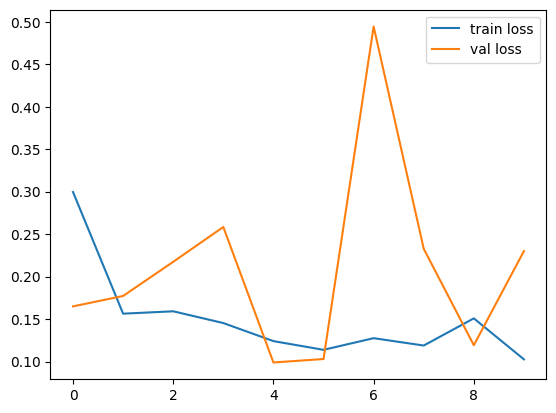

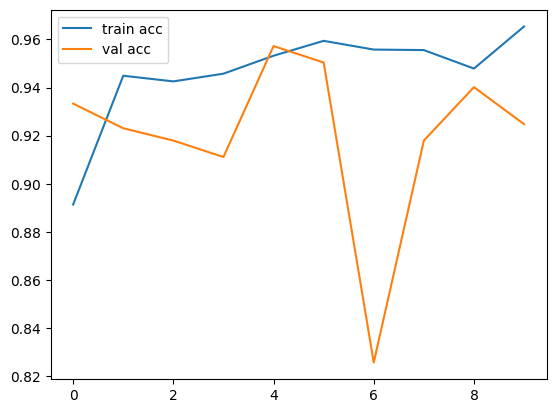

<Figure size 640x480 with 0 Axes>

In [38]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')

plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [39]:
test_loss, test_acc = model.evaluate(test_set)
print('Test accuracy:', test_acc)

19/19 [==============================] - 5s 242ms/step - loss: 0.2008 - accuracy: 0.9302
Test accuracy: 0.9301533102989197


In [40]:
from sklearn.metrics import classification_report


y_pred = model.predict(test_set)

print(classification_report(np.argmax(test_labels,axis=1), np.argmax(y_pred,axis=1)))

19/19 [==============================] - 5s 253ms/step
              precision    recall  f1-score   support

           0       0.24      0.30      0.26       159
           1       0.71      0.65      0.68       428

    accuracy                           0.56       587
   macro avg       0.48      0.47      0.47       587
weighted avg       0.59      0.56      0.57       587



In [21]:
import tensorflow as tf

from keras.models import load_model

model.save('model_vgg19.h5')

In [ ]:
def show_image(img_name):
  img = plt.imread(img_name)
  plt.imshow(img)
  plt.show()